# MINE Mutual Information Estimation in Zero-Dispersion Optical Channel 

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Using the MINE mutual information estimator to compute the achievable information rate (AIR) of the channel

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Simple real-valued AWGN channel, with channel output $r_i = t_i + n_i$ where $\mathsf{n} \sim \mathcal{N}(0,\sqrt{N_0/(2E_{\mathrm{s}})})$. Note that we define $E_{\mathrm{s}}/N_0$ as if we had a complex-valued channel of which we only use the real-part.

In [7]:
def simulate_channel(x, EsN0):      
    EsN0_lin = 10**(EsN0/10.0)
    sigma = np.sqrt(1.0/2.0/EsN0_lin)
    
    y = x + sigma * np.random.randn(len(x))
    
    return x,y

The MINE estimator [1] uses the Donsker-Varadhan variational represention of the mutual information, which is given by
$$
I(\mathsf{t};\mathsf{r}) = \sup_{f:\mathcal{T}\times\mathcal{R}\to\mathbb{R}}\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t},\mathsf{r})}\{f(\mathsf{t},\mathsf{r})\} - \log\left(\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}\right)
$$
where $f:\mathcal{T}\times\mathcal{R}\to\mathbb{R}$ is any function that maps input and output of the channel to a scalar value. The maximization ("$\sup$") needs to be carried out over all such functions. In this example, we use a neural network to approximate this variational function. The neural network is implemented in the next block and consists of two hidden layers with ELU activation function. We need to make sure that the function is numerically stable and therefore use an initializer for the initial weights with very small variance.

[1] M. Belghazi, A. Baratin, S. Rajeswar, S. Ozair, Y. Bengio, A. Courville, and R. D. Hjelm, "MINE: Mutual information
neural estimation," __Proc. ICML__, preprint available at \url{https://arxiv.org/abs/1801.04062}, 2018

In [10]:
class Variational_Function(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2):
        super(Variational_Function, self).__init__()
        
        # Linear function, 2 input neurons (channel input and channel output)
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()           
    
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  

        # Output layer generating a scalar
        self.fc3 = nn.Linear(hidden_neurons_2, 1)
                
        # initialize weights of layers
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)                
        
        # Linear function, output layer
        out = self.fc3(out)

        return out

Carry out the final optimization. We use the Adam algorithm with small learning rate and use a modification of the cost function, which leads to a more stable estimator.

Let $J(\boldsymbol{t}, \boldsymbol{r}, \boldsymbol{\theta})$ be the loss function. Then we exploit the fact that with
$$
J(\boldsymbol{t}, \boldsymbol{r}, \boldsymbol{\theta}) := \mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t},\mathsf{r})}\{f(\mathsf{t},\mathsf{r})\} - \log\left(\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}\right)
$$ we have
\begin{align*}
\nabla_{\boldsymbol{\theta}}J(\boldsymbol{t}, \boldsymbol{r}, \boldsymbol{\theta}) &= \nabla_{\boldsymbol{\theta}}\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t},\mathsf{r})}\{f(\mathsf{t},\mathsf{r})\} - \frac{\nabla_{\boldsymbol{\theta}}\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}}{\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}}
\end{align*}
Applying stochastic gradient descent over the batch with $N$ examples yields
\begin{align*}
\nabla_{\boldsymbol{\theta}}J(\boldsymbol{t}, \boldsymbol{r}, \boldsymbol{\theta}) &\approx \frac{1}{N}\sum_{i=1}^N\nabla_{\boldsymbol{\theta}}f(t_i,r_i) - \frac{\frac{1}{N}\sum_{i=1}^N\nabla_{\boldsymbol{\theta}}\mathrm{e}^{f(t_i,\tilde{r}_i)}}{\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}}
\end{align*}
where $r_i$ is the result of transmitting $t_i$ over the channel and $\tilde{r}_i$ is the result of transmitting $\tilde{t}_i$ over the channel, where we discard the transmit sequence $\tilde{t}_i$. This needs to be done to ensure that the expectation is taken over the product of marginal distributions ($\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\{\cdot\}$). For details, see [1].

In the denominator of the approximated gradient, we have the term $\mathbb{E}_{\mathsf{t},\mathsf{r}\sim p(\mathsf{t})p(\mathsf{r})}\left\{\mathrm{e}^{f(\mathsf{t},\mathsf{r})}\right\}$. We estimate this term using a moving average over the mini-batches. We need to make sure that this term is not taken into account when calculating the gradient, which is done using the `.detach()` function. The original loss function is also available in the code below as a comment.

In [11]:
EsN0 = 0.0

MI_reference = 0.5*np.log2(1 + 2 * 10.0**(EsN0/10.0))

hidden_neurons_1 = 50
hidden_neurons_2 = 30


# Generate variational function
model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
model.to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

num_epochs = 20
batches_per_epoch = 1000

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(400, 20000, num=num_epochs, dtype=int)

ma_et = 0.0


for epoch in range(num_epochs):
    for step in range(batches_per_epoch):
        
        
        t,r = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        _,rtilde = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        
        model.train()
                
        # generate input to first call of the variational function
        input_1 = np.vstack( (t, r) ).transpose()
        torch_in1 = torch.from_numpy(input_1).float().to(device)
        
        # generate input to second call of the variational function
        input_2 = np.vstack( (t, rtilde) ).transpose()
        torch_in2 = torch.from_numpy(input_2).float().to(device)
        
        # apply the variational function
        out_1 = model(torch_in1)
        out_2 = model(torch_in2)
        
        
        # loss function. Attenation, put a minus sign as we want to maximize
        #oss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))
        
        tmp = torch.exp(out_2)
        ma_et = (1.0-0.05)*ma_et + 0.05*torch.mean(tmp.detach())        
        loss = -torch.mean(out_1) + (1/ma_et.mean()).detach() * torch.mean(tmp)               
                
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
    model.eval()
    t,r = simulate_channel(np.random.randn(10000), EsN0)
    _,rtilde = simulate_channel(np.random.randn(10000), EsN0)
        
        
    # generate input to first call of the variational function
    input_1 = np.vstack( (t,r) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)
        
    # generate input to second call of the variational function
    input_2 = np.vstack( (t,rtilde) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)
        
    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)
        
    # loss function. Attenation, put a minus sign as we want to maximize
    MI_eval = torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))
    print('Epoch %d: current MI estimate is %1.3f bit/channel use (reference: %1.3f bit/channel use)' % (epoch, MI_eval.cpu().detach().numpy(), MI_reference) )




Epoch 0: current MI estimate is 0.727 bit/channel use (reference: 0.792 bit/channel use)
Epoch 1: current MI estimate is 0.735 bit/channel use (reference: 0.792 bit/channel use)
Epoch 2: current MI estimate is 0.728 bit/channel use (reference: 0.792 bit/channel use)
Epoch 3: current MI estimate is 0.736 bit/channel use (reference: 0.792 bit/channel use)
Epoch 4: current MI estimate is 0.724 bit/channel use (reference: 0.792 bit/channel use)
Epoch 5: current MI estimate is 0.735 bit/channel use (reference: 0.792 bit/channel use)
Epoch 6: current MI estimate is 0.733 bit/channel use (reference: 0.792 bit/channel use)
Epoch 7: current MI estimate is 0.774 bit/channel use (reference: 0.792 bit/channel use)
Epoch 8: current MI estimate is 0.753 bit/channel use (reference: 0.792 bit/channel use)
Epoch 9: current MI estimate is 0.733 bit/channel use (reference: 0.792 bit/channel use)
Epoch 10: current MI estimate is 0.760 bit/channel use (reference: 0.792 bit/channel use)
Epoch 11: current MI

Show the convergence of the training

In [29]:
EsN0 = 5.0

MI_reference = 0.5*np.log2(1 + 2 * 10.0**(EsN0/10.0))

hidden_neurons_1 = 100
hidden_neurons_2 = 100


# Generate variational function
model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
model.to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)  

num_epochs = 1000
batches_per_epoch = 2

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(10000, 10000, num=num_epochs, dtype=int)

ma_et = 0.0

# Progress bar
f = IntProgress(min=0, max=num_epochs) # instantiate the bar
display(f) # display the bar

MI_eval = np.zeros(num_epochs)
for epoch in range(num_epochs):
    for step in range(batches_per_epoch):
        
        
        t,r = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        _,rtilde = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        
        model.train()
                
        # generate input to first call of the variational function
        input_1 = np.vstack( (t, r) ).transpose()
        torch_in1 = torch.from_numpy(input_1).float().to(device)
        
        # generate input to second call of the variational function
        input_2 = np.vstack( (t, rtilde) ).transpose()
        torch_in2 = torch.from_numpy(input_2).float().to(device)
        
        # apply the variational function
        out_1 = model(torch_in1)
        out_2 = model(torch_in2)
        
        
        # loss function. Attenation, put a minus sign as we want to maximize
        #loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))
        
        tmp = torch.exp(out_2)
        ma_et = (1.0-0.1)*ma_et + 0.1*torch.mean(tmp.detach())        
        loss = -torch.mean(out_1) + (1/ma_et.mean()).detach() * torch.mean(tmp)               
                
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
    model.eval()
    t,r = simulate_channel(np.random.randn(10000), EsN0)
    _,rtilde = simulate_channel(np.random.randn(10000), EsN0)
        
        
    # generate input to first call of the variational function
    input_1 = np.vstack( (t,r) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)
        
    # generate input to second call of the variational function
    input_2 = np.vstack( (t,rtilde) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)
        
    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)
        
    # loss function. Attenation, put a minus sign as we want to maximize
    MI_eval[epoch] = (torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))).cpu().detach().numpy()
    f.value += 1
    #print('Epoch %d: current MI estimate is %1.3f bit/channel use (reference: %1.3f bit/channel use)' % (epoch, MI_eval.cpu().detach().numpy(), MI_reference) )




IntProgress(value=0, max=1000)

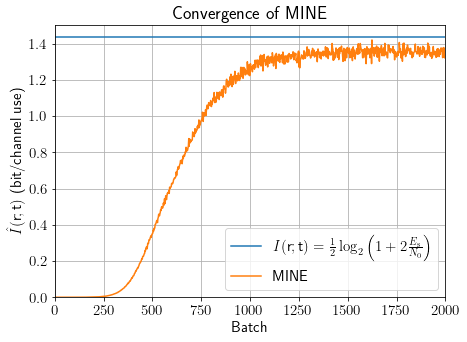

In [33]:
# plotting options 
import matplotlib
font = {'size'   : 15}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

plt.figure(figsize=(7,5))
plt.plot(np.arange(num_epochs)*2, MI_reference * np.ones(num_epochs))
plt.plot(np.arange(num_epochs)*2, MI_eval)
plt.xlim((0,2000))
plt.ylim((0,1.5))
plt.grid(True)
plt.legend([r'${I}(\mathsf{r};\mathsf{t}) = \frac{1}{2} \log_2\left(1+2\frac{E_{\mathrm{s}}}{N_0}\right)$','MINE'])
plt.title('Convergence of MINE');
plt.xlabel('Batch')
plt.ylabel('$\\hat{I}(\mathsf{r};\mathsf{t})$ (bit/channel use)')

#plt.savefig('MINE_Convergence.pdf',bbox_inches='tight')

Now we train a GMM for each constellation point individually. We will use this one to compute the mutual information (and hence the performance of a transmission scheme) later

In [36]:
def MINE_getMI_AWGN(EsN0):
    # Generate variational function
    model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
    model.to(device)

    # Adam Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  

    num_epochs = 200
    batches_per_epoch = 250

    # increase batch size while learning from 100 up to 10000
    batch_size_per_epoch = np.linspace(400, 20000, num=num_epochs, dtype=int)

    ma_et = 0;
    MI_eval = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):
            t,r = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
            _,rtilde = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)

            model.train()

            # generate input to first call of the variational function
            input_1 = np.vstack( (t, r) ).transpose()
            torch_in1 = torch.from_numpy(input_1).float().to(device)

            # generate input to second call of the variational function
            input_2 = np.vstack( (t, rtilde) ).transpose()
            torch_in2 = torch.from_numpy(input_2).float().to(device)

            # apply the variational function
            out_1 = model(torch_in1)
            out_2 = model(torch_in2)


            # loss function. Attenation, put a minus sign as we want to maximize
            #loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))
            tmp = torch.exp(out_2)
            ma_et = (1.0-0.05)*ma_et + 0.05*torch.mean(tmp.detach())        
            loss = -torch.mean(out_1) + (1/ma_et.mean()).detach() * torch.mean(tmp.detach() * out_2)       

            # compute gradients
            loss.backward() 

            # carry out one optimization step with Adam
            optimizer.step()

            # reset gradients to zero
            optimizer.zero_grad()
        
        model.eval()
        t,r = simulate_channel(np.random.randn(100000), EsN0)
        _,rtilde = simulate_channel(np.random.randn(100000), EsN0)


        # generate input to first call of the variational function
        input_1 = np.vstack( (t,r) ).transpose()
        torch_in1 = torch.from_numpy(input_1).float().to(device)

        # generate input to second call of the variational function
        input_2 = np.vstack( (t,rtilde) ).transpose()
        torch_in2 = torch.from_numpy(input_2).float().to(device)

        # apply the variational function
        out_1 = model(torch_in1)
        out_2 = model(torch_in2)

        # Obtain mutual information
        MI_eval[epoch] = (torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))).cpu().detach().numpy()

    return np.max(MI_eval)

Show performance over a range of $E_{\mathrm{s}}/N_0$.

In [37]:
num_elements = 10
esno_range = np.linspace(-10,10, num_elements)


f = IntProgress(min=0, max=num_elements) # instantiate the bar
display(f) # display the bar

MI_ref = np.zeros(num_elements)
MI_MINE = np.zeros(num_elements)

for i,esno in enumerate(esno_range):
    MI_ref[i] = 0.5*np.log2(1 + 2 * 10.0**(esno/10.0))
    MI_MINE[i] = MINE_getMI_AWGN(esno)
    
    # increase progress bar
    f.value += 1

IntProgress(value=0, max=10)

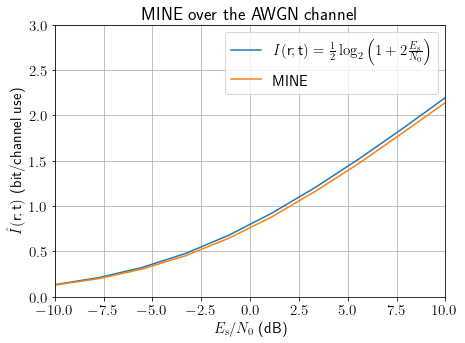

In [38]:
# plotting options 
import matplotlib
font = {'size'   : 15}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

plt.figure(figsize=(7,5))
plt.plot(esno_range, MI_ref)
plt.plot(esno_range, MI_MINE)
plt.xlim((-10,10))
plt.ylim((0,3))
plt.grid(True)
plt.legend([r'${I}(\mathsf{r};\mathsf{t}) = \frac{1}{2} \log_2\left(1+2\frac{E_{\mathrm{s}}}{N_0}\right)$','MINE'])
plt.title('MINE over the AWGN channel');
plt.xlabel('$E_{\mathrm{s}}/N_0$ (dB)')
plt.ylabel('$\\hat{I}(\mathsf{r};\mathsf{t})$ (bit/channel use)')

#plt.savefig('MINE_AWGN.pdf',bbox_inches='tight')